- ajouter cluster des dataset corrects
- maybe cluster avec en x l'angle et en y la dist du snout à la tailbase
- mettre autre méthode de corruption
- rajouter max du random ds méthode de corruption

In [114]:
import numpy as np
import pandas as pd
import math
import deeplabcut
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 14, 6
%matplotlib inline

In [115]:
path = 'openfield-Pranav-2018-08-20'
original = f'{path}/labeled-data-correct/m1s1/CollectedData_Pranav.csv'
target_csv = f'{path}/labeled-data/m1s1/CollectedData_Pranav.csv'
target_h5 = f'{path}/labeled-data/m1s1/CollectedData_Pranav.h5'

path_config_file = f'{path}/config.yaml'
# read the configure file - config.yaml
cfg = deeplabcut.auxiliaryfunctions.read_config(path_config_file)
# get the scorer name / bodyparts
scorer = cfg['scorer']
bodyparts = cfg['bodyparts']

In [116]:
from FunctionsLib import distance_keypoints
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')
dist = distance_keypoints(df,'snout','tailbase')

# check if there are any NaN values
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)

data = pd.DataFrame(data=dist, index=df.index, columns=None)

# remove any NaN values from our distances dataset
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
data = clean_dataset(data)
#df.plot()

scorer                          Pranav                                    \
bodyparts                        snout          leftear         rightear   
coords                               x       y        x       y        x   
labeled-data/m1s1/img0109.png  266.333  59.667  269.667  71.000    279.0   
labeled-data/m1s1/img0110.png  317.667  72.000  330.333  51.667      NaN   

scorer                                                
bodyparts                             tailbase        
coords                              y        x     y  
labeled-data/m1s1/img0109.png  53.333      NaN   NaN  
labeled-data/m1s1/img0110.png     NaN    313.0  58.0  


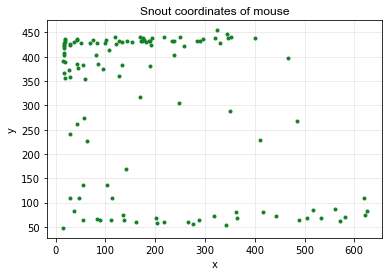

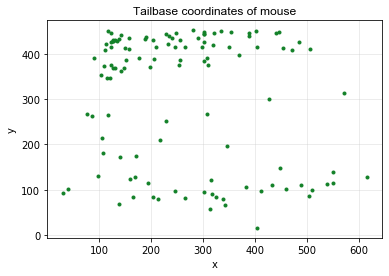

In [117]:
# plotting x and y coordinates of snout and tailbase
# snout
_ = plt.plot(df.loc[:][(scorer,bodyparts[0],'x')],df.loc[:][(scorer,bodyparts[0], 'y')],marker='.',linewidth=0, color='#128128')
_ = plt.grid(which='major',color='#cccccc', alpha = 0.45)
_ = plt.title('Snout coordinates of mouse', family='Arial', fontsize=12)
_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.show()

# tailbase
__ = plt.plot(df.loc[:][(scorer,bodyparts[3],'x')],df.loc[:][(scorer,bodyparts[3], 'y')],marker='.',linewidth=0, color='#128128')
__ = plt.grid(which='major',color='#cccccc', alpha = 0.45)
__ = plt.title('Tailbase coordinates of mouse', family='Arial', fontsize=12)
__ = plt.xlabel('x')
__ = plt.ylabel('y')
__ = plt.show()

#### DBSCAN clustering algorithm

In [118]:
# Prepare data for model
dbscan_data = data
dbscan_data = dbscan_data.values.astype('float32')

# Normalize data
dbscan_data_scaler = StandardScaler().fit(dbscan_data)
dbscan_data = dbscan_data_scaler.transform(dbscan_data)

# Construct model
model = DBSCAN(eps=0.25,min_samples=10,metric='euclidean').fit(dbscan_data)
model

DBSCAN(eps=0.25, min_samples=10)

In [119]:
# Separate outliers from clustered data
outliers_df = data[model.labels_==-1]
clusters_df = data[model.labels_!=-1]

colors = model.labels_
colors_clusters = colors[colors != -1]
color_outliers = 'black'

# Get info abuot the clusters
clusters = Counter(model.labels_)
print(clusters)
print(data[model.labels_ == -1].head())
print('Number of clusters = {}'.format(len(clusters)-1))

Counter({0: 102, -1: 13})
                                        0
labeled-data/m1s1/img0018.png  193.320449
labeled-data/m1s1/img0022.png   80.267010
labeled-data/m1s1/img0044.png  381.394391
labeled-data/m1s1/img0064.png   74.166334
labeled-data/m1s1/img0078.png   81.939002
Number of clusters = 1


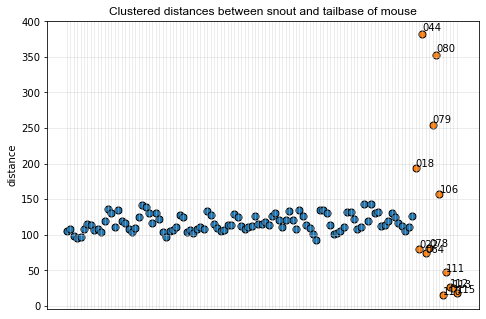

In [120]:
import re
# Plot clusters and outliers
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

ax.scatter(clusters_df.index,clusters_df, edgecolors='black',s=50)
ax.scatter(outliers_df.index,outliers_df, edgecolors='black',s=50)

plt.title('Clustered distances between snout and tailbase of mouse', family='Arial',fontsize=12)

'''
names = []
for name in df.index:
    string = "".join(re.findall(r'\d',name))
    id = string[2:]
    names.append(id)
ax.set_xticklabels(names)
'''

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

for row in outliers_df.iterrows():
    string = "".join(re.findall(r'\d',row[0]))
    id = string[3:]
    plt.text(row[0], row[1]*(1.015), str(id))

plt.ylabel('distance')

plt.grid(which='major',color='#cccccc', alpha=0.45)
plt.show()

In [121]:
# look for frames where bodyparts (like right and left ear) might have been swapped
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')
snout = df.xs('snout', level='bodyparts', axis=1).to_numpy()
rightear = df.xs('rightear', level='bodyparts', axis=1).to_numpy()
leftear = df.xs('leftear', level='bodyparts', axis=1).to_numpy()

# calculate the angle 
def getAngle(a,b,c):
    angle = math.degrees(math.atan2(c[1]-b[1],c[0]-b[0]) - math.atan2(a[1]-b[1],a[0]-b[0]))
    return angle

angles = []
swapped_frames = []
not_swapped = []
for (a,b,c) in zip(leftear,snout,rightear):
    angles.append(getAngle(a,b,c))
    if getAngle(a,b,c) > 0:
        swapped_frames.append(getAngle(a,b,c))
    else:
        not_swapped.append(getAngle(a,b,c))
        
#print(swapped_frames)
#print(not_swapped)
#this still needs work

In [122]:
data = pd.DataFrame(data=angles, index=df.index, columns=None)
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
data = clean_dataset(data)

In [123]:
# Prepare data for model
dbscan_data = data
dbscan_data = dbscan_data.values.astype('float32')

# Normalize data
dbscan_data_scaler = StandardScaler().fit(dbscan_data)
dbscan_data = dbscan_data_scaler.transform(dbscan_data)

# Construct model
model = DBSCAN(eps=0.25,min_samples=10,metric='euclidean').fit(dbscan_data)
model

DBSCAN(eps=0.25, min_samples=10)

In [124]:
# Separate outliers from clustered data
outliers_df = data[model.labels_==-1]
clusters_df = data[model.labels_!=-1]

colors = model.labels_
colors_clusters = colors[colors != -1]
color_outliers = 'black'

# Get info abuot the clusters
clusters = Counter(model.labels_)
print(clusters)
print(data[model.labels_ == -1].head())
print('Numebr of clusters = {}'.format(len(clusters)-1))

Counter({0: 94, 1: 11, -1: 10})
                                        0
labeled-data/m1s1/img0021.png -261.819752
labeled-data/m1s1/img0040.png  112.218278
labeled-data/m1s1/img0064.png   38.153255
labeled-data/m1s1/img0072.png  292.263277
labeled-data/m1s1/img0089.png   74.108292
Numebr of clusters = 2


In [125]:
'''
# Plot clusters and outliers
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

ax.scatter(clusters_df.index,clusters_df, edgecolors='black',s=50)
ax.scatter(outliers_df.index,outliers_df, edgecolors='black',s=50)

plt.title('Clustered angles between snout and ears of mouse', family='Arial',fontsize=12)


plt.grid(which='major',color='#cccccc', alpha=0.45)

plt.show()
'''

"\n# Plot clusters and outliers\nfig = plt.figure()\n\nax = fig.add_axes([.1,.1,1,1])\n\nax.scatter(clusters_df.index,clusters_df, edgecolors='black',s=50)\nax.scatter(outliers_df.index,outliers_df, edgecolors='black',s=50)\n\nplt.title('Clustered angles between snout and ears of mouse', family='Arial',fontsize=12)\n\n\nplt.grid(which='major',color='#cccccc', alpha=0.45)\n\nplt.show()\n"

### K-means clustering algorithm

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [127]:
from FunctionsLib import distance_keypoints,clean_dataset

df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')
dist = distance_keypoints(df,'snout','tailbase')

# check if there are any NaN values 
nan_rows = df[df.isna().any(axis=1)] 
#print(nan_rows) 

data = pd.DataFrame(data=dist, index=df.index, columns=None)
data = clean_dataset(data)
data.columns = ['distance snout-tailbase']
data.head()
data.describe()
#print(data)
#df.plot()

,distance snout-tailbase
count,115.000000
mean,118.286950
std,43.034047
min,14.757401
25%,106.765805
50%,113.338412
75%,127.071475
max,381.394391


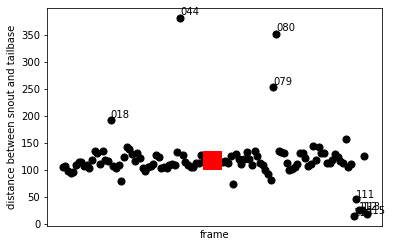

In [128]:
plt.scatter(data.index, data, s = 50, c = 'black')
plt.scatter(56, 118.28695027, s=300, c='r', marker='s')

for row in data.iterrows():
    if float(row[1]) > 160 or float(row[1]) < 50: #kind of a random treshold based on the data, need to find better
        string = "".join(re.findall(r'\d',row[0]))
        id = string[3:]
        plt.text(row[0], row[1]*(1.015), str(id))

plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
plt.ylabel('distance between snout and tailbase')
plt.xlabel('frame')

plt.show()

In [129]:
# defining the kmeans function
kmeans = KMeans(n_clusters=1)

# fitting the k means algorithm on data
kmeans.fit(data)
y_kmeans = kmeans.predict(data)

In [130]:
#kmeans.inertia_
#kmeans.cluster_centers_

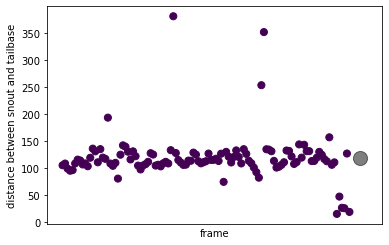

In [131]:
plt.scatter(data.index, data, c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
plt.ylabel('distance between snout and tailbase')
plt.xlabel('frame')
plt.scatter(centers, centers, c='black', s=200, alpha=0.5)

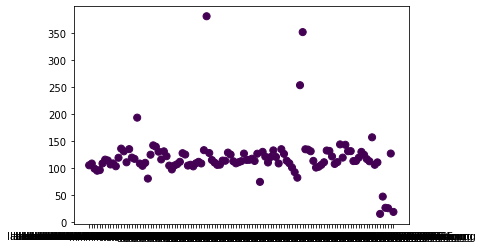

In [132]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=1, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(data)
plt.scatter(data.index,data, c=labels,s=50, cmap='viridis');

Text(0, 0.5, 'Inertia')

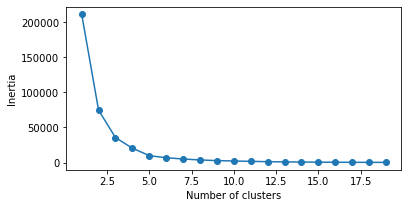

In [138]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(6,3))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [134]:
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 5, init='k-means++')
kmeans.fit(data)
pred = kmeans.predict(data)

In [135]:
frame = pd.DataFrame(data)
frame['cluster'] = pred
frame['cluster'].value_counts()

0    64
2    42
3     5
4     2
1     2
Name: cluster, dtype: int64



### K-means clustering algorithm: distances between all keypoints

In [136]:
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')

dist_st = distance_keypoints(df,'snout','tailbase')
dist_sr = distance_keypoints(df,'snout','rightear')
dist_sl = distance_keypoints(df,'snout','leftear')
dist_rt = distance_keypoints(df,'rightear','tailbase')
dist_lt = distance_keypoints(df,'leftear','tailbase')

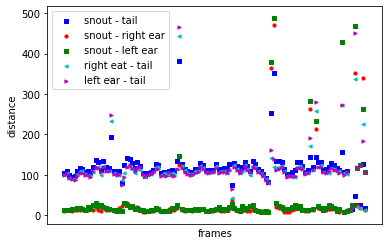

In [137]:
x = range(100)
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

ax1.scatter(df.index, dist_st, s=10, c='b', marker="s", label='snout - tail')
ax1.scatter(df.index, dist_sr, s=10, c='r', marker="o", label='snout - right ear')
ax1.scatter(df.index, dist_sl, s=10, c='g', marker="s", label='snout - left ear')
ax1.scatter(df.index, dist_rt, s=10, c='c', marker="<", label='right eat - tail')
ax1.scatter(df.index, dist_lt, s=10, c='m', marker=">", label='left ear - tail')
plt.legend(loc='upper left');
plt.ylabel('distance')
plt.xlabel('frames')

plt.show()

In [255]:
### using distance between the keypoints (a 4x4 matrix) then reshape them to a 1-d vector as our input of clustering
# SR = snout - right ear, SL = snout - left eat, RT = right ear - tail, LT = left ear - tail

from FunctionsLib import clean_dataset

data = pd.DataFrame(zip(dist_sr,dist_sl,dist_rt,dist_lt),columns=['SR','SL','RT','LT'])
data = clean_dataset(data)

clean_data = clean_dataset(data)
from_snout = clean_data[['SR', 'SL']].to_numpy()
from_tail = clean_data[['RT', 'LT']].to_numpy()

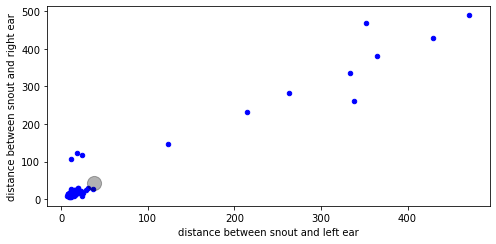

In [262]:
plt.scatter(from_snout[:,0], from_snout[:,1], s = 20, c = 'b')

plt.ylabel('distance between snout and right ear')
plt.xlabel('distance between snout and left ear')

plt.scatter(37.80219035, 43.6913904, c='black', s=200, alpha=0.3)

plt.show()

In [257]:
# defining the kmeans function
kmeans = KMeans(n_clusters=1)

# fitting the k means algorithm on data
kmeans.fit(data[['SR', 'SL']])
y_kmeans = kmeans.predict(data[['SR', 'SL']])

In [259]:
centers = kmeans.cluster_centers_
print(centers)

[[37.80219035 43.6913904 ]]


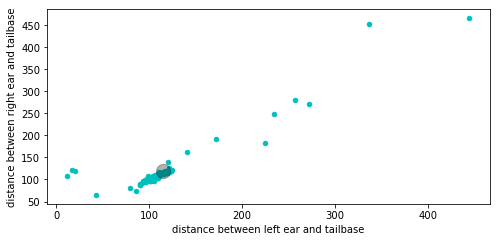

In [265]:
plt.scatter(from_tail[:,0], from_tail[:,1], s = 20, c = 'c')
plt.scatter(115.2164855, 118.73451039, c='black', s=200, alpha=0.3)

plt.ylabel('distance between right ear and tailbase')
plt.xlabel('distance between left ear and tailbase')

plt.show()

In [263]:
# defining the kmeans function
kmeans = KMeans(n_clusters=1)

# fitting the k means algorithm on data
kmeans.fit(data[['RT', 'LT']])
y_kmeans = kmeans.predict(data[['RT', 'LT']])

centers = kmeans.cluster_centers_
print(centers)

[[115.2164855  118.73451039]]


In [295]:
d = clean_data.to_numpy().flatten()
d = d.reshape(-1, 1)

# defining the kmeans function
kmeans = KMeans(n_clusters=4)

# fitting the k means algorithm on data
kmeans.fit(d)
y_kmeans = kmeans.predict(d)

centers = kmeans.cluster_centers_
print(centers)

[[116.35478917]
 [ 22.78150819]
 [100.7742568 ]
 [ 12.43311278]]


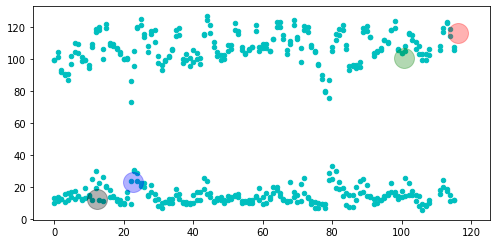

In [296]:
plt.scatter(np.repeat(np.array(clean_data.index),4), d, s = 20, c = 'c')

plt.scatter(12.43311278, 12.43311278, c='black', s=400, alpha=0.3)
plt.scatter(116.10551233, 116.10551233, c='red', s=400, alpha=0.3)
plt.scatter(22.78150819, 22.78150819, c='blue', s=400, alpha=0.3)
plt.scatter(100.60144603, 100.60144603, c='green', s=400, alpha=0.3)


#plt.ylabel('distance between right ear and tailbase')
#plt.xlabel('distance between left ear and tailbase')

plt.show()

### nice to compare with the correct values clustered

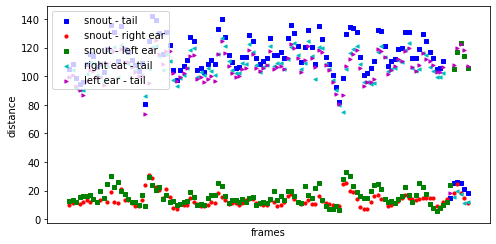

In [266]:
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data-correct\m1s1\CollectedData_Pranav.h5')

dist_st = distance_keypoints(df,'snout','tailbase')
dist_sr = distance_keypoints(df,'snout','rightear')
dist_sl = distance_keypoints(df,'snout','leftear')
dist_rt = distance_keypoints(df,'rightear','tailbase')
dist_lt = distance_keypoints(df,'leftear','tailbase')

x = range(100)
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

ax1.scatter(df.index, dist_st, s=10, c='b', marker="s", label='snout - tail')
ax1.scatter(df.index, dist_sr, s=10, c='r', marker="o", label='snout - right ear')
ax1.scatter(df.index, dist_sl, s=10, c='g', marker="s", label='snout - left ear')
ax1.scatter(df.index, dist_rt, s=10, c='c', marker="<", label='right eat - tail')
ax1.scatter(df.index, dist_lt, s=10, c='m', marker=">", label='left ear - tail')
plt.legend(loc='upper left');
plt.ylabel('distance')
plt.xlabel('frames')

plt.show()

In [267]:
from FunctionsLib import clean_dataset

data = pd.DataFrame(zip(dist_sr,dist_sl,dist_rt,dist_lt),columns=['SR','SL','RT','LT'])
data = clean_dataset(data)

clean_data = clean_dataset(data)
from_snout = clean_data[['SR', 'SL']].to_numpy()
from_tail = clean_data[['RT', 'LT']].to_numpy()

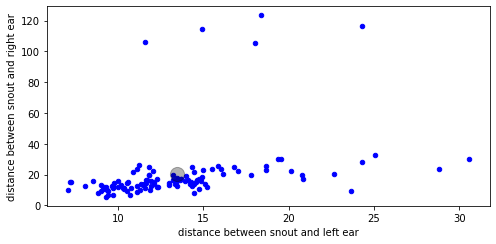

In [270]:
plt.scatter(from_snout[:,0], from_snout[:,1], s = 20, c = 'b')

plt.ylabel('distance between snout and right ear')
plt.xlabel('distance between snout and left ear')

plt.scatter(13.46917956, 20.23349553, c='black', s=200, alpha=0.3)

# find a treshold at which it would be interesting to look at the frames to see if the labels are correct

plt.show()

In [269]:
# defining the kmeans function
kmeans = KMeans(n_clusters=1)

# fitting the k means algorithm on data
kmeans.fit(data[['SR', 'SL']])
y_kmeans = kmeans.predict(data[['SR', 'SL']])

centers = kmeans.cluster_centers_
print(centers)

[[13.46917956 20.23349553]]


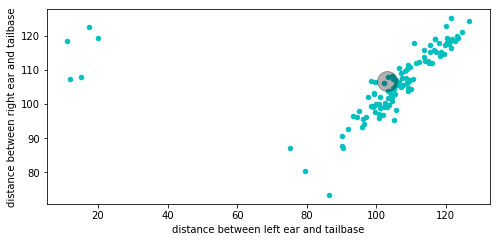

In [275]:
plt.scatter(from_tail[:,0], from_tail[:,1], s = 20, c = 'c')
plt.scatter(103.16252632, 106.79874196, c='black', s=400, alpha=0.3)

plt.ylabel('distance between right ear and tailbase')
plt.xlabel('distance between left ear and tailbase')

plt.show()

In [273]:
# defining the kmeans function
kmeans = KMeans(n_clusters=1)

# fitting the k means algorithm on data
kmeans.fit(data[['RT', 'LT']])
y_kmeans = kmeans.predict(data[['RT', 'LT']])

centers = kmeans.cluster_centers_
print(centers)

[[103.16252632 106.79874196]]
